In [1]:
import os
import time
import random
import re
import pandas as pd
import numpy as np
import jieba
import pickle

%matplotlib inline

In [2]:
def dump_pickle(obj,fname):
    with open(fname,'wb') as file:
        pickle.dump(obj,file)
def load_pickle(fname):
    return pickle.load(open(fname,'rb'))

In [3]:
claim_df = pd.read_pickle('../data/patent_data/processed/claim_df_seg_0630.pkl')

In [4]:
patent_text = claim_df.seg_text.tolist()
patent_text = [' '.join(i) for i in patent_text]

# 向量化 使用tfidf 重新训练 限定词表

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
patent_tfidf_obj = load_pickle('../data/patent_data/processed/patent_tfidf_obj_1wdim_0701.pkl')

In [7]:
patent_all_tfidf_matrix = patent_tfidf_obj.transform(patent_text)

# 样例数据准备

In [40]:
sample_patent_data_tfidf = patent_tfidf_obj.transform(patent_text[:10000])

# 聚类 使用Mean-Shift进行聚类

bandwidth 是搜索时使用的带宽大小 可以设置

也可以使用estimate_bandwidth来进行估测

In [57]:
from sklearn.cluster import MeanShift,estimate_bandwidth

In [59]:
# band_est = estimate_bandwidth(sample_patent_data_tfidf.toarray())

# ms = MeanShift(bandwidth=band_est)

# ms.fit(sample_patent_data_tfidf.toarray())

# ms_cluster = ms.predict(sample_patent_data_tfidf.toarray())

# 聚类 使用 k-means 对文档进行聚类

In [41]:
from sklearn.cluster import KMeans

In [42]:
km = KMeans(n_clusters=5)

In [43]:
km.fit_transform(sample_patent_data_tfidf)

array([[ 1.00841548,  0.99087066,  1.02410152,  1.07876093,  0.98209814],
       [ 0.95629668,  0.9796529 ,  1.01082593,  1.08068262,  0.99275461],
       [ 0.98369832,  0.98360408,  1.01230311,  1.07970272,  0.96535078],
       ..., 
       [ 0.96476077,  0.97748875,  1.01392698,  1.06831709,  0.96618604],
       [ 0.97214395,  0.97892954,  1.0108723 ,  1.08039938,  0.99372075],
       [ 1.00755017,  0.97629563,  1.01070328,  1.08646999,  1.0097385 ]])

In [44]:
km_cluster = km.predict(sample_patent_data_tfidf)

# 聚类 使用 TSNE

tsne 降维之后可以得到所有点在空间中对应的布局 在此基础上使用kmeans得到的聚类分组进行可视化

In [45]:
import bokeh
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

In [46]:
from sklearn.manifold.t_sne import TSNE

In [47]:
tsne_obj_2d = TSNE(n_components=2)

In [48]:
tsne_cluster_2d = tsne_obj_2d.fit_transform(sample_patent_data_tfidf.toarray())

In [49]:
tsne_cluster_2d.shape

(10000, 2)

# 2D TSNE结果绘图

In [50]:
colormap = ['#DC143C','#0000CD','#00FFFF','#008000','#FFD700']

p = figure(title = "Patent claim cluster")
p.xaxis.axis_label = 'Dim 1'
p.yaxis.axis_label = 'Dim 2'

km_colors = [colormap[i] for i in km_cluster]

p.circle([i[0] for i in tsne_cluster_2d], [i[1] for i in tsne_cluster_2d],color=km_colors,fill_alpha=0.2, size=10)

output_notebook()
show(p)

Loading BokehJS ...

# 3D TSNE结果绘图

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [52]:
tsne_obj_3d = TSNE(n_components=3)
tsne_cluster_3d = tsne_obj_3d.fit_transform(sample_patent_data_tfidf.toarray())

Text(0.5,0,'Z Label')

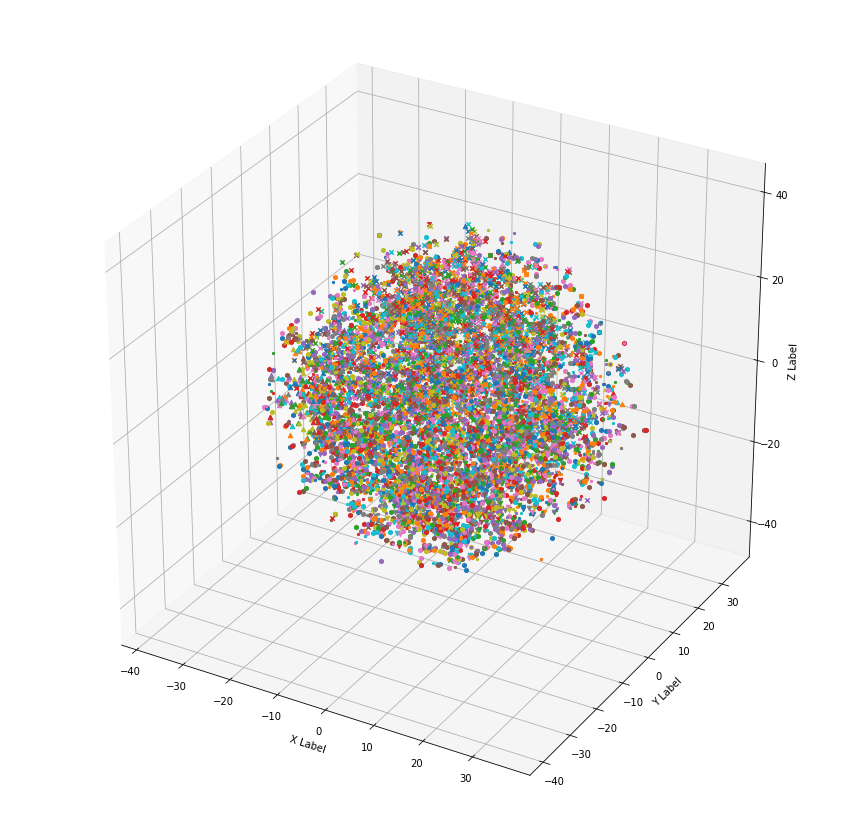

In [53]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
marker_map = ['.','h','v','^','x']

for num,tsne_3d in enumerate(tsne_cluster_3d):
    xs = tsne_3d[0]
    ys = tsne_3d[1]
    zs = tsne_3d[2]
    mark = marker_map[km_cluster[num]]
    
    ax.scatter(xs,ys,zs,marker=mark)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')    

# 3D 交互式绘图

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

init_notebook_mode(connected=True)
xs,ys,zs = [],[],[]
color = []
for num,tsne_3d in enumerate(tsne_cluster_3d):
    xs.append(tsne_3d[0])
    ys.append(tsne_3d[1])
    zs.append(tsne_3d[2])
    color.append(colormap[km_cluster[num]])
    
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=color,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig)